In [257]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize
from priordist import PriorDistributionCell
import matplotlib.pyplot as plt
import textwrap
from preproc import *
import pickle

In [111]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181101"

# Save directory for figures and data files
figsave_dir = f'figures/{day_dir}/infogain'

### Preprocessing of rplparallel, spiketrain, vmpv, raycast data

In [112]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp_file = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp_file.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.round(np.array(rp.get('timeStamps')), 3)
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)
rp_file.close()

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    try:
        spk_file = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except NotImplementedError:
        spk_file = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except FileNotFoundError:
        continue
    spk = np.array(spk_file.get('timestamps')).flatten() # spike timestamps is loaded in as a column vector
    spk /= 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    if isinstance(spk_file, h5py.File):
        spk_file.close()
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv_file = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv_file.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)
pv_file.close()

In [113]:
# Define important constants
num_cells = len(cell_labels)
num_goals = 6
time_res = 0.001
tbin_size = 0.1

In [114]:
# Get trial outcomes from trial markers
# 0 for unsuccessful trials, 1 for successful trials
trial_outcomes = 4 - trial_markers[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]

In [115]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_outcomes = trial_outcomes[trial_filt]
trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt]
nav_intervals = nav_intervals[trial_filt]
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
trial_trajectories = trial_trajectories[trial_filt]

Cue phase data

In [116]:
# Preallocate list of arrays for spike counts per time bin in cue phase
# Then slot spikes into cue phase intervals, using time bin resolution specified by tbin_size
timebins_cue, spikecounts_cue = list(), list()
for trial in cue_intervals:
    st_time, ed_time = trial
    ed_time = st_time + 10 * tbin_size
    timebins_cue_trial = np.hstack([np.arange(st_time, ed_time, tbin_size).reshape(-1,1), np.arange(st_time, ed_time, tbin_size).reshape(-1,1) + tbin_size])
    timebins_cue.append(timebins_cue_trial)
    spikecounts_cue.append(np.array(spike_counts_per_observation(timebins_cue_trial, spike_times)))

# Convert spike counts to average spike rates across duration of cue phase
spikerates_cue = [trial/tbin_size for trial in spikecounts_cue]

Full session data

In [117]:
# Preallocate list of arrays for spike counts per time bin in each trial
# Then slot spikes into trial intervals, using time bin resolution specified by tbin_size
timebins_session, spikecounts_session = list(), list()
for trial in trial_intervals:
    st_time, ed_time = trial
    timebins_session_trial = np.hstack([np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1), np.arange(st_time, ed_time-tbin_size, tbin_size).reshape(-1,1) + tbin_size])
    timebins_session.append(timebins_session_trial)
    spikecounts_session.append(np.array(spike_counts_per_observation(timebins_session_trial, spike_times)))

# Convert spike counts to average spike rates
spikerates_session = [trial/tbin_size for trial in spikecounts_session]

Spike count distribution plots

Text(0, 0.5, 'Spike count')

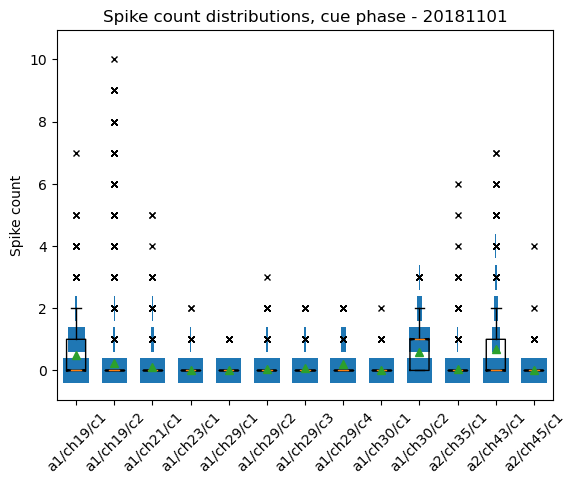

In [118]:
# Distribution of cue phase spike counts
spikecounts_cue_all = np.vstack(spikecounts_cue)
histdata_cue = [np.histogram(data, bins=int(max(data)-min(data)+1))[0] for data in spikecounts_cue_all.T]
histranges_cue = [np.arange(int(min(data)), int(max(data))+1) for data in spikecounts_cue_all.T]

plt.figure()
plt.title(f'Spike count distributions, cue phase - {day_dir}')
plt.boxplot(spikecounts_cue_all, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
for i in range(len(histdata_cue)):
    plt.barh(histranges_cue[i], histdata_cue[i]/(3*max(histdata_cue[i])), left=i+1, color='C0')
    plt.barh(histranges_cue[i], -histdata_cue[i]/(3*max(histdata_cue[i])), left=i+1, color='C0')
plt.xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)
plt.ylabel('Spike count')

Text(0, 0.5, 'Spike count')

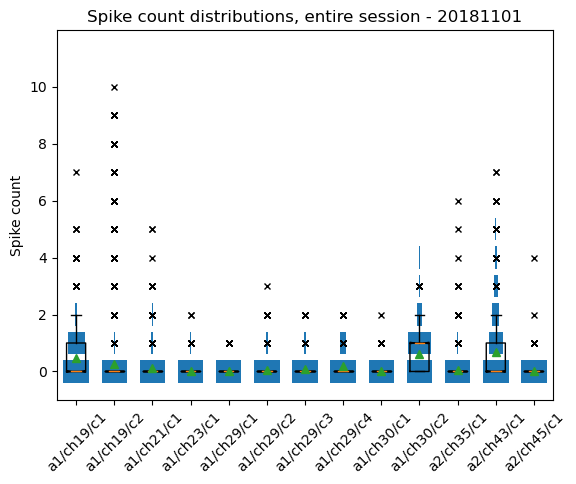

In [119]:
# Distribution of spike counts for entire session
spikecounts_session_all = np.vstack(spikecounts_session)
histdata_session = [np.histogram(data, bins=int(max(data)-min(data)+1))[0] for data in spikecounts_session_all.T]
histranges_session = [np.arange(int(min(data)), int(max(data))+1) for data in spikecounts_session_all.T]

plt.figure()
plt.title(f'Spike count distributions, entire session - {day_dir}')
plt.boxplot(spikecounts_cue_all, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
for i in range(len(histdata_session)):
    plt.barh(histranges_session[i], histdata_session[i]/(3*max(histdata_session[i])), left=i+1, color='C0')
    plt.barh(histranges_session[i], -histdata_session[i]/(3*max(histdata_session[i])), left=i+1, color='C0')
plt.xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)
plt.ylabel('Spike count')

### Cue phase information gain

In [120]:
class PriorDistributionCell:
    # Generates prior distribution for a given set of responses against a given set of stimuli,
    # with response mapping done at individual cell level
    # Spike counts are fitted to a Poisson distribution

    def fit_poisson_distribution(responses: np.array) -> np.array:
        # Takes in (n x l) 2-D array of (l cells) population responses across (n number of) observations
        # Fits a Poisson distribution to each cell's responses, returns estimated parameter (lambda)
        def neg_log_likelihood(params, data):
            return -np.sum(poisson.logpmf(data, params[0]))
        lambdas = np.empty(responses.shape[1])
        for i in range(responses.shape[1]):
            init_params = [np.mean(responses[:,i])]
            res = minimize(neg_log_likelihood, init_params, args=(responses[:,i],), bounds=[(0, None)])
            lambdas[i] = res.x[0]
        return lambdas
    
    def estimate_pmf(responses: np.array) -> np.array:
        res = list()
        for i in range(responses.shape[1]):
            unique_vals, counts = np.unique(responses[:,i], return_counts=True)
            unique_vals = unique_vals.astype(int)
            counts = counts / responses.shape[0]
            res.append(dict(zip(unique_vals, counts)))
        return res

    def __init__(self, responses: np.array, responses_per_stimulus: np.array):
        self.num_s = len(responses_per_stimulus)
        self.r_dist = PriorDistributionCell.estimate_pmf(responses)
        self.s_dist = np.empty(self.num_s)
        self.r_s_dist = list()
        for i, resps in enumerate(responses_per_stimulus):
            resps = np.vstack(resps)
            self.s_dist[i] = resps.shape[0]
            self.r_s_dist.append(PriorDistributionCell.estimate_pmf(resps))
        self.s_dist = np.divide(self.s_dist, np.sum(self.s_dist), dtype=np.float64)
        # self.r_s_dist = np.vstack(self.r_s_dist)

    def P_r(self, resp: int, cell: int) -> float:
        # Returns probability of observing a given response for a given cell
        # return poisson.pmf(resp, self.r_dist[cell])
        return self.r_dist[cell].get(resp, 0)

    def P_s(self, stim: int) -> float:
        # Returns probability of ocuurence of a given stimulus
        return self.s_dist[stim]

    def P_r_s(self, resp: int, stim: int,  cell: int) -> float:
        # Returns probability of observing a given response for a given cell, given a specific stimulus
        # return poisson.pmf(resp, self.r_s_dist[stim, cell])
        return self.r_s_dist[stim][cell].get(resp, 0)

In [121]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    # num_goals = 6
    grouped = [list() for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal].append(timeseries[idx])
    return grouped

def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): list() for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)].append(timeseries[idx])
    return grouped

def information_gain(response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    info_gain = np.zeros((num_goals, num_cells))
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_dist.P_r_s(cell, cat, goal)
                P_r = response_dist.P_r(cell, cat)
                if P_r_s != 0:
                    info_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
    return info_gain

def net_information_gain(info_gain: np.array, response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    net_info_gain = np.zeros(num_cells)
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = info_gain[goal, cell]
            P_s = response_dist.P_s(goal)
            net_info_gain[cell] += P_s * I_s_R
    return net_info_gain

In [122]:
def custom_slice(arr, idx):
    res = list()
    for goal in arr:
        subres = list()
        for obs in goal:
            subres.append(obs[idx,:])
        res.append(subres)
    return res

spikecounts_cue_per_goal = group_by_goal(spikecounts_cue, trial_markers)
num_prds = 10
spikecounts_cue_distribution = list()
for prd in range(num_prds):
    spikecounts_cue_distribution.append(PriorDistributionCell(spikecounts_session_all, custom_slice(spikecounts_cue_per_goal, prd)))

In [123]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = spikecounts_cue_distribution[0].P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(goal_entropy)

2.580981259664602


In [124]:
# Unconditioned entropy of responses across entire session
session_entropy = np.zeros(num_cells)
for cell in range(num_cells):
    for resp in spikecounts_cue_distribution[0].r_dist[cell].keys():
        P_r = spikecounts_cue_distribution[0].P_r(resp, cell)
        if P_r != 0:
            session_entropy[cell] -= P_r * np.log2(P_r)

print(session_entropy)

[1.21734796 0.32209585 0.42762061 0.14737325 0.09910877 0.36648507
 0.41432921 0.76649997 0.0245828  1.45537055 0.30569461 1.96971359
 0.1556352 ]


In [125]:
# Conditioned entropy of responses per goal
goal_response_entropy = np.zeros((num_goals, num_cells, num_prds))
for goal in range(num_goals):
    for cell in range(num_cells):
        for prd in range(num_prds):
            for resp in spikecounts_cue_distribution[prd].r_s_dist[goal][cell].keys():
                P_r_s = spikecounts_cue_distribution[prd].P_r_s(resp, goal, cell)
                if P_r_s != 0:
                    goal_response_entropy[goal, cell, prd] -= P_r_s * np.log2(P_r_s)

In [126]:
# Information gain per stimulus (relative to entire session responses)
information_gain = np.zeros((num_goals, num_cells, num_prds))
for goal, responses in enumerate(spikecounts_cue_per_goal):
    for cell in range(num_cells):
        for prd in range(num_prds):
            for resp in spikecounts_cue_distribution[prd].r_s_dist[goal][cell].keys():
                P_r_s = spikecounts_cue_distribution[prd].P_r_s(resp, goal, cell)
                P_r = spikecounts_cue_distribution[prd].P_r(resp, cell)
                if P_r != 0:
                    information_gain[goal, cell, prd] += P_r_s * np.log2(P_r_s / P_r)

In [127]:
# Net information gain acrosss entire stimuli set
net_information_gain = np.zeros((num_cells, num_prds))
for prd in range(num_prds):
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = information_gain[goal, cell, prd]
            P_s = spikecounts_cue_distribution[prd].P_s(goal)
            net_information_gain[cell, prd] += P_s * I_s_R

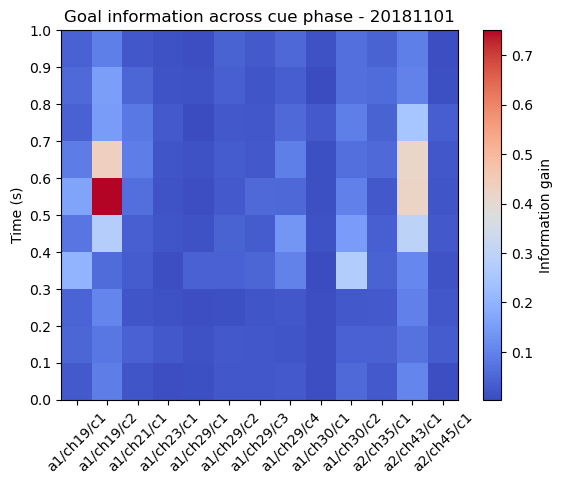

In [128]:
plt.figure()
plt.pcolormesh(net_information_gain.T, cmap='coolwarm')
plt.colorbar(label='Information gain')
plt.title(f'Goal information across cue phase - {day_dir}')
plt.ylabel('Time (s)')
plt.xticks(np.arange(0.5, num_cells+0.5), cell_labels, rotation=45)
plt.yticks(np.arange(int(1/tbin_size)+1), [f'{tbin_size * i:.1f}' for i in range(0, int(1/tbin_size)+1)])
plt.show()

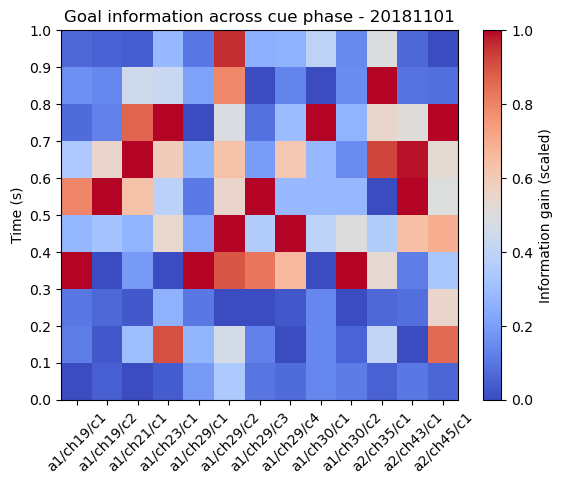

In [129]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def scale_values(arr: np.array) -> np.array:
    res = np.empty_like(arr)
    tot = np.sum(arr)
    if tot == 0:
        tot = 1
    for i, val in enumerate(arr):
        res[i] = val / tot
    return res

net_information_gain_scaled = np.empty_like(net_information_gain)
for idx, row in enumerate(net_information_gain):
    net_information_gain_scaled[idx,:] = minmax_scale(row)

plt.figure()
plt.pcolormesh(net_information_gain_scaled.T, cmap='coolwarm')
plt.colorbar(label='Information gain (scaled)')
plt.title(f'Goal information across cue phase - {day_dir}')
plt.ylabel('Time (s)')
plt.xticks(np.arange(0.5, num_cells+0.5), cell_labels, rotation=45)
plt.yticks(np.arange(int(1/tbin_size)+1), [f'{tbin_size * i:.1f}' for i in range(0, int(1/tbin_size)+1)])
plt.show()

### Save data to pkl file

In [130]:
# Save to pickle file
datasave_dir = 'data/infogain'
for i, label in enumerate(cell_labels):
    label = label.split('/')
    label[1] = label[1][2:]
    if label[1][0] == '0':
        label[1] = label[1][1:]
    cell_labels[i] = f'{day_dir}ch{label[1]}{label[2]}'

data = {'cell_labels': cell_labels, 'net_information_gain': net_information_gain, 'net_information_gain_scaled': net_information_gain_scaled}

if not os.path.exists(datasave_dir):
    os.makedirs(datasave_dir)
with open(f'{datasave_dir}/{day_dir}_data.pkl', 'wb') as file:
    pickle.dump(data, file)

### Plots with cells from multiple sessions

In [165]:
# Load data from saved .pkl files
day_list = ['20181105', '20181102', '20181101']

all_cell_labels = list()
all_net_information_gain = list()
all_net_information_gain_scaled= list()

for day in day_list:
    with open(f'data/infogain/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        all_cell_labels.extend(data['cell_labels'])
        all_net_information_gain.append(data['net_information_gain'])
        all_net_information_gain_scaled.append(data['net_information_gain_scaled'])

all_net_information_gain = np.vstack(all_net_information_gain)
all_net_information_gain_scaled = np.vstack(all_net_information_gain_scaled)
num_all_cells = len(all_cell_labels)
for i, label in enumerate(all_cell_labels):
    all_cell_labels[i] = all_cell_labels[i][4:]

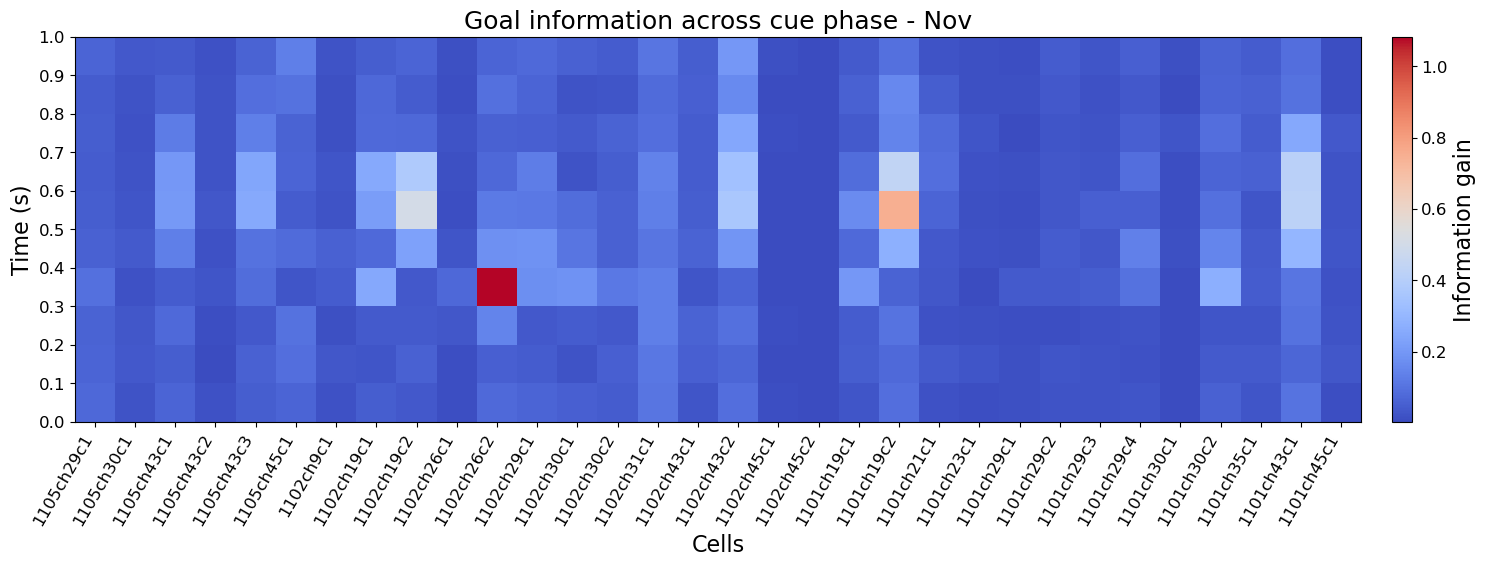

In [194]:
plt.figure(figsize=(20, 5))
plt.rcParams['font.size'] = 12
plt.pcolormesh(all_net_information_gain.T, cmap='coolwarm')
cbar = plt.colorbar(pad=0.02)
cbar.set_label('Information gain', size=16)
plt.title(f'Goal information across cue phase - Nov', fontsize=18)
plt.xlabel('Cells', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.xticks(np.arange(0.5, num_all_cells+0.5), all_cell_labels, rotation=60, ha='right', va='top')
plt.yticks(np.arange(int(1/tbin_size)+1), [f'{tbin_size * i:.1f}' for i in range(0, int(1/tbin_size)+1)], ha='right')
plt.show()

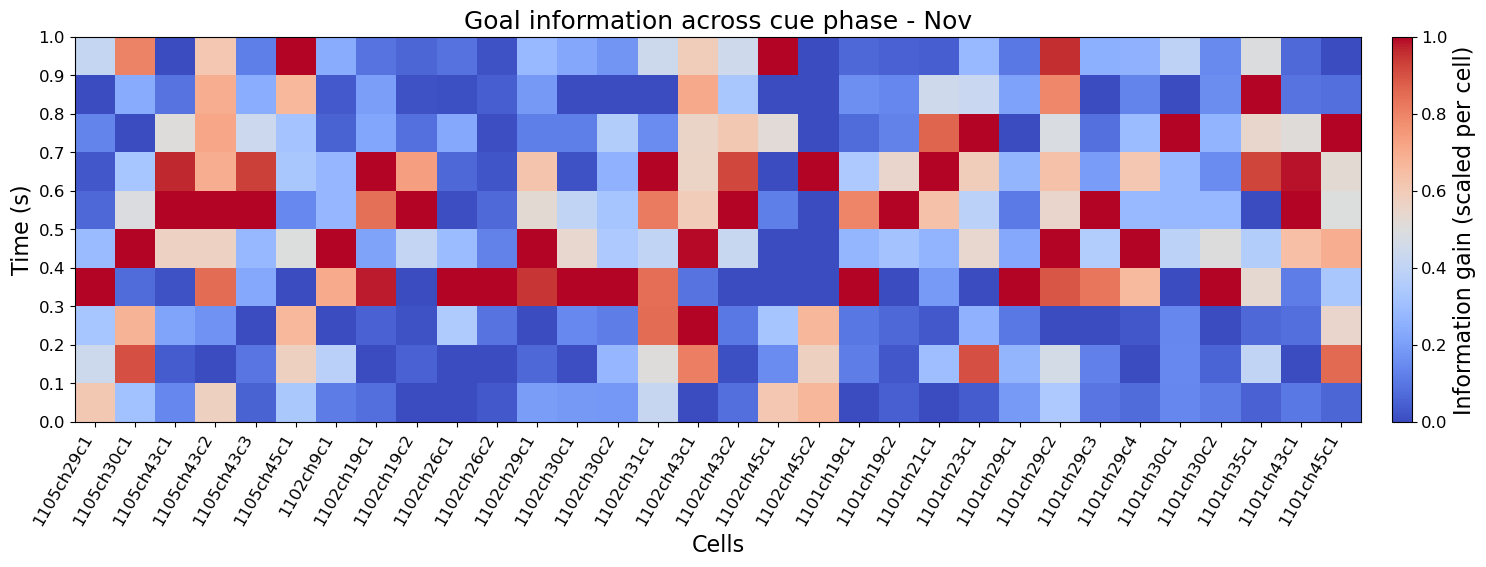

In [192]:
plt.figure(figsize=(20, 5))
plt.rcParams['font.size'] = 12
plt.pcolormesh(all_net_information_gain_scaled.T, cmap='coolwarm')
cbar = plt.colorbar(pad=0.02)
cbar.set_label('Information gain (scaled per cell)', size=16)
plt.title(f'Goal information across cue phase - Nov', fontsize=18)
plt.xlabel('Cells', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.xticks(np.arange(0.5, num_all_cells+0.5), all_cell_labels, rotation=60, ha='right', va='top')
plt.yticks(np.arange(int(1/tbin_size)+1), [f'{tbin_size * i:.1f}' for i in range(0, int(1/tbin_size)+1)], ha='right')
plt.show()

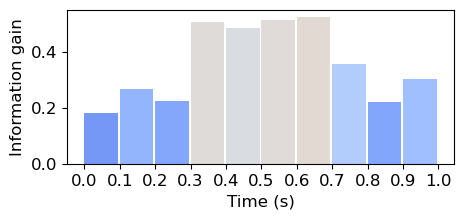

In [223]:
# Plot distribution of information gain across the cue phase, collapsed across all cells
all_net_information_gain_scaled_mean = np.mean(all_net_information_gain_scaled, axis=0)
plt.figure(figsize=(5, 2))
colormap = plt.cm.coolwarm(all_net_information_gain_scaled_mean)
plt.bar(np.arange(0, 1, 0.1), all_net_information_gain_scaled_mean, width=0.095, align='edge', color=colormap)
plt.xlabel('Time (s)')
plt.ylabel('Information gain')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_6500/752435363.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(pcm, pad=0.08)


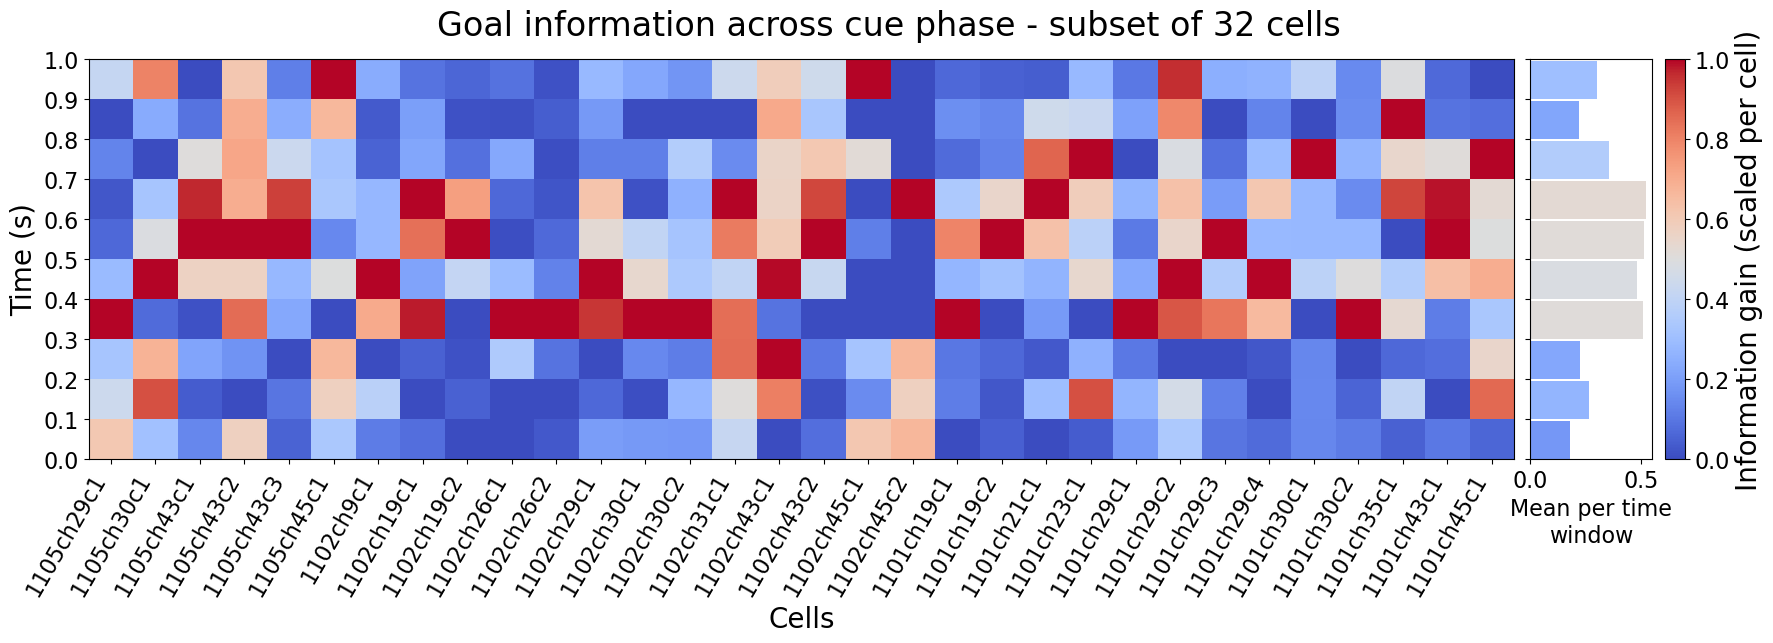

In [273]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [9, 1]})
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.02, hspace=0)
plt.rcParams['font.size'] = 16

pcm = ax1.pcolormesh(all_net_information_gain_scaled.T, cmap='coolwarm')
cbar = plt.colorbar(pcm, pad=0.08)
cbar.set_label('Information gain (scaled per cell)', size=20)
plt.suptitle(f'Goal information across cue phase - subset of 32 cells', fontsize=24, y=1)
ax1.set_xlabel('Cells', fontsize=20)
ax1.set_ylabel('Time (s)', fontsize=20)
ax1.set_xticks(np.arange(0.5, num_all_cells+0.5), all_cell_labels, rotation=60, ha='right', va='top')
ax1.set_yticks(np.arange(int(1/tbin_size)+1), [f'{tbin_size * i:.1f}' for i in range(0, int(1/tbin_size)+1)], ha='right')

cm = plt.cm.coolwarm(all_net_information_gain_scaled_mean)
ax2.barh(np.arange(int(1/tbin_size)), all_net_information_gain_scaled_mean, height=0.95, align='edge', color=cm)
ax2.set_xlabel(textwrap.fill('Mean per time window', 15))

figsave_dir = 'figures'
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/infogain_Nov2018.eps', bbox_inches='tight')
plt.show()